## SVC and PCA on Parkinson's Data
**Author: Prathyusha Sangam**

### Document Outline
* [About the data](#About-the-data)
* [Project objective](#Project-objective)
* [Step 1: Load and Inspect Data](#Step-1:-Load-and-Inspect-Data)
* [Step 2: Understanding and Cleaning the Data](#Step-2:-Understanding-and-Cleaning-the-Data)
     * [Findings](#Findings)
* [Step 3: Train Test Splits and Data Normalization](#Step-3:-Train-Test-Splits-and-Data-Normalization)
* [Step 4: Linear SVC](#Step-4:-Linear-SVC)
* [Step 5: Investigating RBF and Polynomial kernels](#Step-5:-Investigating-RBF-and-Polynomial-kernels)
* [Step 6: PCA](#Step-6:-PCA)



### About the Data
* The data is obtained from UCI repository, which was originally contributed by the University of Oxford, in  collaboration with the National Centre for Voice and Speech, Denver, Colorado.
* This dataset is composed of a range of biomedical voice measurements from  31 people, 23 with Parkinson's disease (PD).
* Each column is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column).
* Target values correspond to "status" column which is set to 0 for healthy and 1 for PD.

### Project objective
* Perform Classification using SVC and its variants to classify between healthy samples and PD samples.
* Perform PCA by retaining 95% variance
* Comment on the performance

### Step 1: Load and Inspect Data

In [21]:
#Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# allowing multiple/scrollable outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#sklearn metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [2]:
#load data
parkinsons = pd.read_csv("Datasets/parkinsons.data", sep = ',')

#inspecting how data looks like
parkinsons.head()
parkinsons.shape
# parkinsons.info()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


(195, 24)

### Step 2: Understanding and Cleaning the Data

In [3]:
#data cleaning
print("Null Values in data:" , parkinsons.isnull().sum().sum())

parkinsons = parkinsons.drop('name', axis=1)

Null Values in data: 0


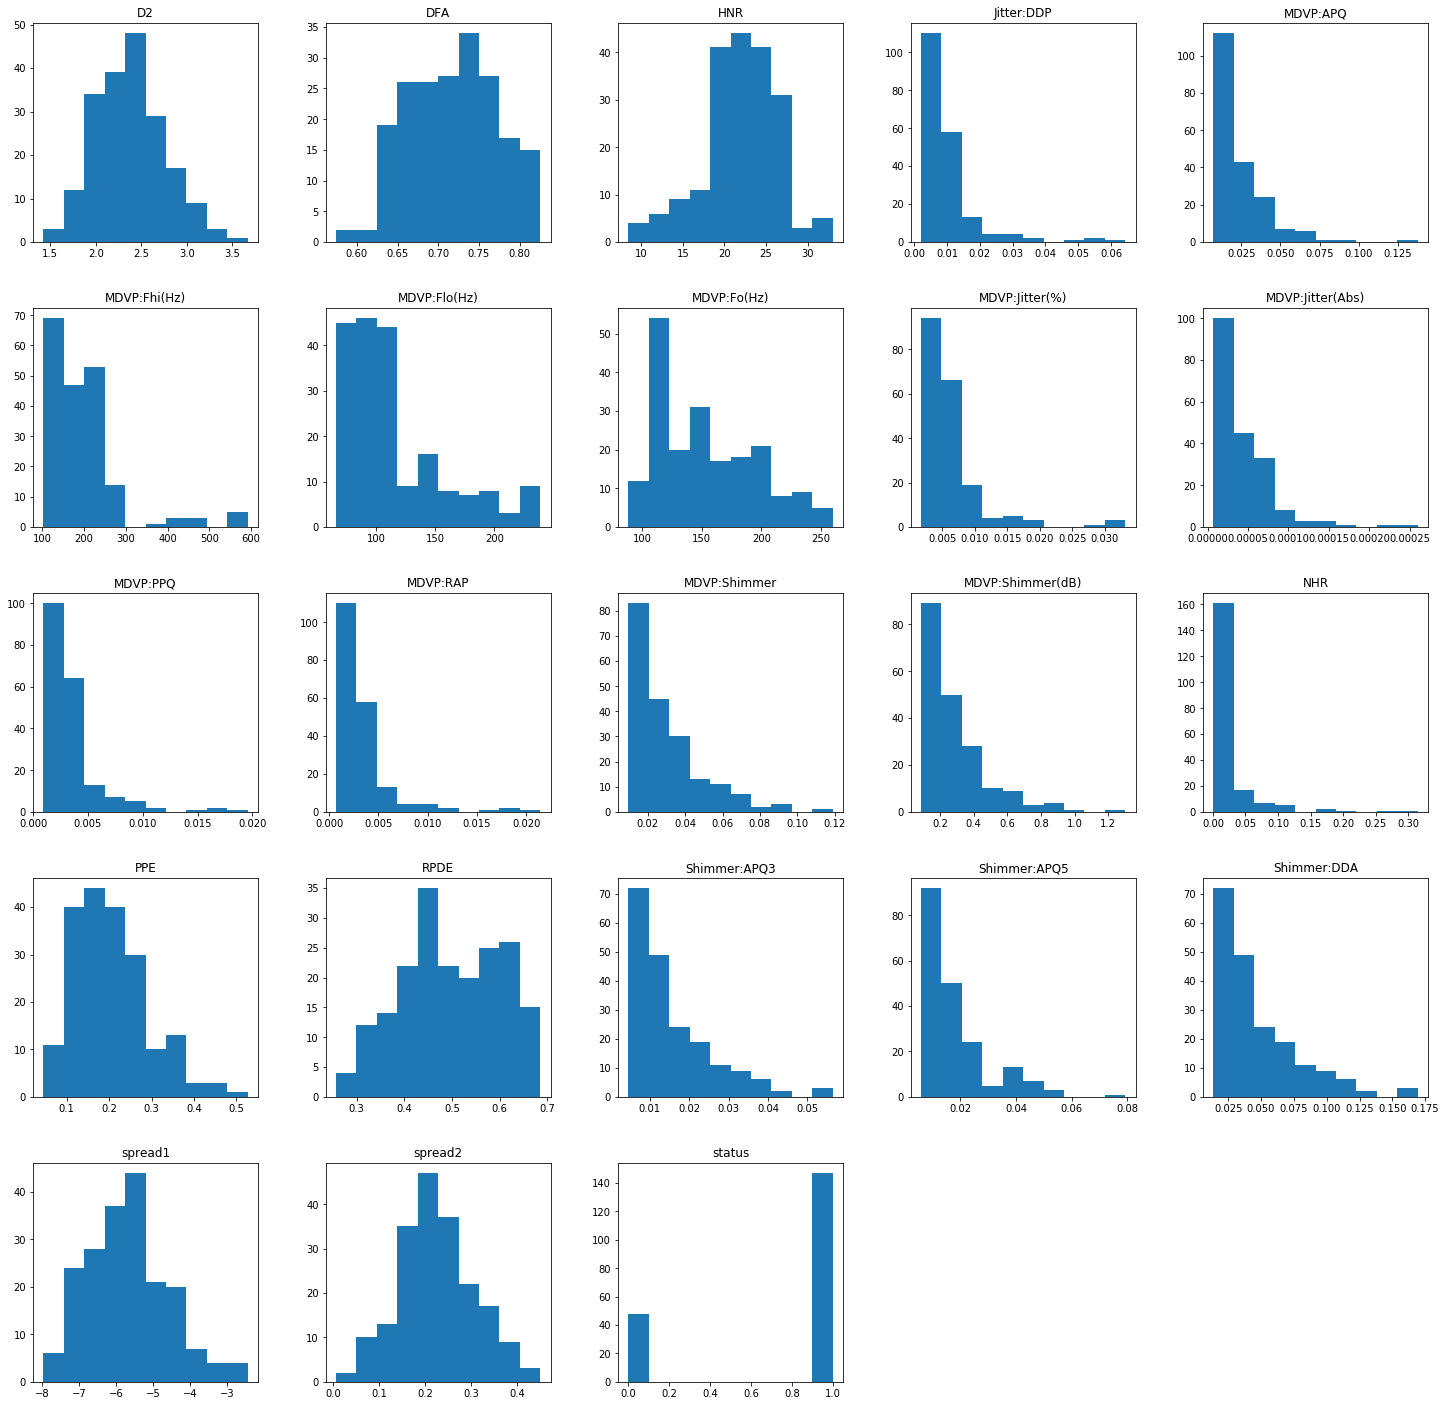

In [4]:
#Histogram to understand - distribution of the attributes
_= parkinsons.hist(layout = (5,5),figsize=(25,25), grid = False)

Text(0.5,1,'Disproportionate distribution of "Status" values')

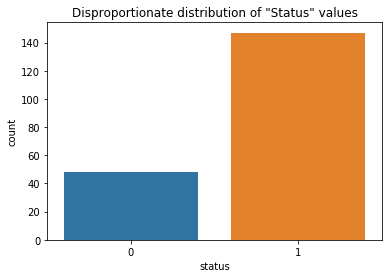

In [5]:
#class distributions
sns.countplot('status',data= parkinsons).set_title('Disproportionate distribution of "Status" values')

#### Findings
* There are no null values in the data to clean
* 'name' column can be dropped since it has no relationship to a patient's status; all other columns will be used.
* The histograms of the attributes show that values are of different scales, also we see their distributions are not normal, **Decision: Scale the features using Standard Scaler.**
* The values of status : 0 and 1 labels are have disproportionate number of samples in the data set. **Decision: We will perform stratified test train splits.**



### Step 3: Train Test Splits and Data Normalization
Before performing the classification task, we will make Train Test splits in 80:20 ratio (industry recommended). Since there are huge variations in number of samples of each category, we perform stratified sampling.

Naming convention of the train-test splits:
* X_train: Training data frame containing features - without labels
* y_train: Target values for training
* X_test: Testing data frame containing features - without targets labels
* y_test: Original data target values of test data

In [6]:
#Separating X and y from original dataframe

X = parkinsons.drop('status',axis=1)
y = parkinsons['status']

# uncomment to inspect the columns chosen
# X.head()
# y.head()

#Test train splits

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state = 42)

# Data Normalization : Feature scaling using Standard scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Step 4: Linear SVC
* Manual Hyperparameter tuning for was done for C=1 (default), C=10, C=0.5
* C=0.5 was found to have best accuracy.

In [7]:
from sklearn.svm import LinearSVC

svc_c05 = LinearSVC(random_state=42, C=0.5)
svc_c05.fit(X_train,y_train)

#For training set
from sklearn.model_selection import cross_val_score
svc_c05_train_score = cross_val_score(svc_c05, X_train, y_train, cv=3,n_jobs=1)

svc_c05_test_score = svc_c05.score(X_test,y_test)

print("Accuracy on Train", svc_c05_train_score )
print("Accuracy on Test", svc_c05_test_score )

#predict for producing classification report
svc_c05_predict_train = svc_c05.predict(X_train)
svc_c05_predict_test = svc_c05.predict(X_test)


#display classification report
print("-----------------------------------------------------------------------------------------------------")
print("CLASSIFICATION REPORT DURING TRAINING: \n",classification_report(y_train, svc_c05_predict_train))
print("-----------------------------------------------------------------------------------------------------")
print("CLASSIFICATION REPORT DURING TESTING: \n",classification_report(y_test, svc_c05_predict_test))

LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Accuracy on Train [0.86792453 0.82692308 0.88235294]
Accuracy on Test 0.9230769230769231
-----------------------------------------------------------------------------------------------------
CLASSIFICATION REPORT DURING TRAINING: 
              precision    recall  f1-score   support

          0       0.79      0.71      0.75        38
          1       0.91      0.94      0.93       118

avg / total       0.88      0.88      0.88       156

-----------------------------------------------------------------------------------------------------
CLASSIFICATION REPORT DURING TESTING: 
              precision    recall  f1-score   support

          0       0.89      0.80      0.84        10
          1       0.93      0.97      0.95        29

avg / total       0.92      0.92      0.92        39



### Step 5: Investigating RBF and Polynomial kernels
* Model 1: kernel = rbf, C=0.5
* Model 2: kernel = poly, C=0.5

In [19]:
from sklearn.svm import SVC
svc_rbf = SVC(random_state=42, C=0.5, kernel = 'rbf')
svc_rbf.fit(X_train,y_train)


# training and testing accuracies
svc_rbf_train_score = cross_val_score(svc_rbf, X_train, y_train, cv=3,n_jobs=1)
svc_rbf_test_score = svc_rbf.score(X_test,y_test)

print("Accuracy on Train", svc_rbf_train_score )
print("Accuracy on Test", svc_rbf_test_score )

#predict for producing classification report
svc_rbf_predict_train = svc_rbf.predict(X_train)
svc_rbf_predict_test = svc_rbf.predict(X_test)

#display classification report
print("-----------------------------------------------------------------------------------------------------")
print("CLASSIFICATION REPORT DURING TRAINING: \n",classification_report(y_train, svc_rbf_predict_train))
print("-----------------------------------------------------------------------------------------------------")
print("CLASSIFICATION REPORT DURING TESTING: \n",classification_report(y_test, svc_rbf_predict_test))

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Accuracy on Train [0.88679245 0.80769231 0.8627451 ]
Accuracy on Test 0.8717948717948718
-----------------------------------------------------------------------------------------------------
CLASSIFICATION REPORT DURING TRAINING: 
              precision    recall  f1-score   support

          0       1.00      0.47      0.64        38
          1       0.86      1.00      0.92       118

avg / total       0.89      0.87      0.85       156

-----------------------------------------------------------------------------------------------------
CLASSIFICATION REPORT DURING TESTING: 
              precision    recall  f1-score   support

          0       1.00      0.50      0.67        10
          1       0.85      1.00      0.92        29

avg / total       0.89      0.87      0.86        39



In [56]:
#poly
svc_poly = SVC(random_state=42, C=0.5, kernel = 'poly',degree= 5)
svc_poly.fit(X_train,y_train)

svc_poly_train_score  = cross_val_score(svc_poly, X_train, y_train, cv=3,n_jobs=1)
svc_poly_test_score = svc_poly.score(X_test,y_test)

print("Accuracy on Train", svc_poly_train_score)
print("Accuracy on Test", svc_poly_test_score)

#predict for producing classification report
svc_poly_predict_train = svc_poly.predict(X_train)
svc_poly_predict_test = svc_poly.predict(X_test)

#display classification report
print("-----------------------------------------------------------------------------------------------------")
print("CLASSIFICATION REPORT DURING TRAINING: \n",classification_report(y_train, svc_poly_predict_train))
print("-----------------------------------------------------------------------------------------------------")
print("CLASSIFICATION REPORT DURING TESTING: \n",classification_report(y_test, svc_poly_predict_test))

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Accuracy on Train [0.86792453 0.82692308 0.88235294]
Accuracy on Test 0.8717948717948718
-----------------------------------------------------------------------------------------------------
CLASSIFICATION REPORT DURING TRAINING: 
              precision    recall  f1-score   support

          0       1.00      0.45      0.62        38
          1       0.85      1.00      0.92       118

avg / total       0.89      0.87      0.85       156

-----------------------------------------------------------------------------------------------------
CLASSIFICATION REPORT DURING TESTING: 
              precision    recall  f1-score   support

          0       1.00      0.50      0.67        10
          1       0.85      1.00      0.92        29

avg / total       0.89      0.87      0.86        39



### Comparing the performances
Of Linear SVC, SVC with RBF kernel and SVC with polynomial kernel (degree = 5 ), all with C=0.5
 
* On comparing the performance based on Accuracy, Linear SVC performed the best.
* With respect to precision and recall, Linear SVC had decent precision recall tradeoff; precision and recall  were almost equal in both train and test phases, for both labels '0' and '1'.
* Both 'rbf' and 'poly' kernels resulted in very low recall and very high precision for label '0' and high recall low precision for label '1' (in both train and test phases)
* Curiously, SVC poly(degree=5), SVC RBF  have very similar accuracies.
* **Overall, for the parkinsons dataset, Linear SVC produces a good outcome** 

In [57]:
models = pd.DataFrame({
    'Accuracy on Test': ['SVC linear', 'SVC rbf', 'SVC poly'],
    'Value': [svc_c05_test_score,svc_rbf_test_score,svc_poly_test_score]})

models

,Accuracy on Test,Value
0,SVC linear,0.923077
1,SVC rbf,0.871795
2,SVC poly,0.871795


### Step 6: PCA
To retain 95% variance in the data, we use n_components = 0.95

Comments / Change in performance of SVC after dimensionality reduction:
* PCA has been done on the same data from previous stages to make the comparision valid (scaled test-train split data).

* Principal axis tries to preserve information of features and standard scaling manipulates the features to fit them with 0 mean and unit variance. These two tasks affect the variance of the data. As there is a necessity of comparing algorithms with and without PCA, and given that SVC needs feature scaling, the choice of performing PCA on scaled data was indeed a challenge.

* After dimensionality reduction, there has been no significant improvement in performance. The accuracies of Linear SVC have decreased, while that of poly SVM increased slightly.

* In cases such as image data, PCA is more helpful due to very large dimensionality. Given that the dataset is small, it doesn't make much difference to the computational performance (with respect to time of training)  whether or not dimensionality is reduced.

* The results of PCA are as below

In [44]:
#perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [61]:
#shape of the reduced dimension

print("22 columns have been reduced to 8")
X_test_pca.shape
X_train_pca.shape

22 columns have been reduced to 8


(39, 8)

(156, 8)

In [58]:
#Linear SVC with pa
svc_pca = LinearSVC(random_state=42, C=0.5)
svc_pca.fit(X_train_pca,y_train)

# Accuracy scores LSVC
print("Linear SVM - PCA, Accuracy on Train", svc_pca.score(X_train_pca, y_train) )
print("Linear SVM - PCA, Accuracy on Test", svc_pca.score(X_test_pca,y_test) )
print("-----------------------------------------------------------------------------------------------------")


#rbf with pca
svc_rbf_pca = SVC(random_state=42, C=0.5, kernel = 'rbf')
svc_rbf_pca.fit(X_train_pca,y_train)

# Accuracy scores poly
print("RBF SVM - PCA, Accuracy on Train", svc_rbf_pca.score(X_train_pca, y_train))
print("RBF SVM - PCA, Accuracy on Test", svc_rbf_pca.score(X_test_pca,y_test))
print("-----------------------------------------------------------------------------------------------------")

#poly with pca
svc_poly_pca = SVC(random_state=42, C=0.5, kernel = 'poly',degree= 5)
svc_poly_pca.fit(X_train_pca,y_train)

# Accuracy scores poly
print("Poly SVM - PCA, Accuracy on Train", svc_poly_pca.score(X_train_pca, y_train))
print("Poly SVM - PCA, Accuracy on Test", svc_poly_pca.score(X_test_pca,y_test))



LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Linear SVM - PCA, Accuracy on Train 0.8461538461538461
Linear SVM - PCA, Accuracy on Test 0.8974358974358975
-----------------------------------------------------------------------------------------------------


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

RBF SVM - PCA, Accuracy on Train 0.8653846153846154
RBF SVM - PCA, Accuracy on Test 0.8974358974358975
-----------------------------------------------------------------------------------------------------


SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

Poly SVM - PCA, Accuracy on Train 0.9423076923076923
Poly SVM - PCA, Accuracy on Test 0.8974358974358975


**REFERENCES:**

Textbook: Hands-On Machine Learning with Scikit-Learn and TensorFlow
Python / Scikit Learn documentation